In [1]:
import numpy as np
import scipy 
import scipy.sparse as sparse
import no_J_free_pump as api
import matplotlib.pyplot as plt
import cvxpy as cp

np.random.seed(0)

In [2]:
# Initialize parameters and SDR constraint
N_omega = 11
omega = np.linspace(-2, 2, N_omega)
N_z = 2
z = np.linspace(0, 2*10**-3, N_z)
delta_z = np.abs(z[1] - z[0])
green_fs = api.get_green_f(omega,z)
projection = np.zeros((N_omega, N_omega))
projections = []
sdr_def_constr = []
sdr_cst = []
for i in range(N_omega):
    for j in range(N_omega):
        proj_copy = projection.copy()
        proj_copy[i, j] = 1
        projections.append(sparse.csc_matrix(proj_copy))
        sdr_def_constr.append(api.sdr_def_constr(N_omega, N_z, sparse.csc_matrix(proj_copy)))
        if i == j:
            sdr_cst.append(2.)
        else:
            sdr_cst.append(0.)

In [3]:
# When the pump is a Gaussian, the Schmidt modes become an anti-diagonal identit...
beta_vec = np.exp(-(np.linspace(omega[0], omega[-1], 2*N_omega - 1)**2)/0.4)#np.random.random(2*N_omega - 1)#scipy.special.hermite(1)(np.linspace(omega[0], omega[-1], 2*N_omega - 1))*
beta = scipy.linalg.hankel(beta_vec[:N_omega], beta_vec[N_omega - 1:])
beta_weight = np.sqrt(np.trace(beta.conj().T@beta))
new_beta = beta/beta_weight
delta_k = 1.j*np.diag(omega)
Q_plus = delta_k + beta
Q_minus = delta_k - beta
W_plus = [scipy.linalg.expm(Q_plus*z[i]) for i in range(N_z)]
W_minus = [scipy.linalg.expm(Q_minus*z[i]) for i in range(N_z)]
J = 0.25*(W_plus[-1]@W_plus[-1].conj().T + W_minus[-1]@W_minus[-1].conj().T - 2*np.eye(N_omega))
n = 0.25*np.trace((W_plus[-1] - W_minus[-1]).conj().T@(W_plus[-1] - W_minus[-1]))
W_plus = [(1/np.sqrt(n))*scipy.linalg.expm(Q_plus*z[i]) for i in range(N_z)]
W_minus = [(1/np.sqrt(n))*scipy.linalg.expm(Q_minus*z[i]) for i in range(N_z)]
V, _, W = scipy.linalg.svd(W_plus[-1] - W_minus[-1])
rand_unitary = V@W
X = np.vstack([rand_unitary] + W_plus + W_minus + [new_beta])
Y = np.vstack([rand_unitary] + W_plus + W_minus + [new_beta, np.eye(N_omega)])

In [20]:
# Create constraint matrices
constr_sympl = []
constr_dyn = []
constr_unitary = []
photon_end = api.photon_nbr_constr(N_omega, N_z, n)
photon_nbr_prev = api.photon_nbr_prev_points(N_omega, N_z)
fix_beta = []
for i in range(len(projections)):
    sympl_real, sympl_imag = api.sympl_constr_sdr(N_omega, N_z, projections[i], n)
    dyn_real_plus, dyn_imag_plus, dyn_real_minus, dyn_imag_minus = api.get_dynamics_sdr(omega, z, projections[i], n, beta_weight)
    unitary_constr_real, unitary_constr_imag = api.unitary_constr(N_omega, N_z, projections[i])
    fix_beta_real, fix_beta_imag = api.sdr_fixed_pump(N_omega, N_z, new_beta, projections[i])
    constr_sympl += sympl_real + sympl_imag
    constr_dyn += dyn_real_plus + dyn_imag_plus + dyn_real_minus + dyn_imag_minus
    constr_unitary += [unitary_constr_real + unitary_constr_imag]
    fix_beta += [fix_beta_real, fix_beta_imag]
constr_unitary_trace = api.trace_unitary_mat(N_omega, N_z)
Q_list = api.get_standard_Q(N_omega) + api.get_Q_list(N_omega, 200)
Q_constr_mat = api.ineq_real_any_unitary(N_omega, N_z, Q_list)
imag_obj_f = api.imag_obj_f(N_omega, N_z)
pump_limit = api.limit_pump_power(N_omega, N_z)

In [21]:
# Summing all constraints together
constraints_list = constr_sympl + constr_dyn + constr_unitary + fix_beta + [pump_limit]

In [23]:
[(np.trace(Y.conj().T@constraints_list[i]@Y), i) for i in range(len(constraints_list)) if np.abs(np.trace(Y.conj().T@constraints_list[i]@Y)) > 10**-5]

[]

In [24]:
# Objective function
obj_f = api.obj_f_sdr(N_omega,N_z, n)

In [44]:
# CVXPY model
# The convergence really happens when the photon pair number is fixed
# If even 1 of these constraint is missing, everything goes to shit
variable = cp.Variable(shape = ((2*N_z + 3)*N_omega,(2*N_z + 3)*N_omega), hermitian = True)
constraints = [variable >> 0]
# Constraints about symplectic structure of propagators
constraints += [cp.real(cp.trace(constr_sympl[i]@variable)) == 0 for i in range(len(constr_sympl))]
# Constraints about dynamics
constraints += [cp.real(cp.trace(constr_dyn[i]@variable)) == 0 for i in range(len(constr_dyn))]
# Constraint that the top matrix is unitary
constraints += [cp.real(cp.trace(constr_unitary[i]@variable)) == 0 for i in range(len(constr_unitary))]
# Constraint that defines the problem into a semidefinite relaxation
constraints += [cp.real(cp.trace(sdr_def_constr[i]@variable)) == sdr_cst[i] for i in range(len(sdr_def_constr))]
# Constraint that says the mean photon number at next step is bigger than previous
constraints += [cp.real(cp.trace(photon_nbr_prev[i]@variable)) >= 0 for i in range(len(photon_nbr_prev))]
# Constraint that state the pump is fixed
constraints += [cp.real(cp.trace(fix_beta[i]@variable)) == 0 for i in range(len(fix_beta))]
# B is the best unitary matrix
constraints += [cp.real(cp.trace(Q_constr_mat[i]@variable)) >= 0 for i in range(len(Q_constr_mat))]
# Constraint that defines the photon number at end of waveguide
constraints.append(cp.real(cp.trace(photon_end@variable)) == 0)
# Constraint that gives imaginary part of objective function 0
constraints.append(cp.real(cp.trace(imag_obj_f@variable)) == 0)
# Constraint that maybe the Frobenius norm of beta equal to 1
constraints.append(cp.real(cp.trace(pump_limit@variable)) == 0)
# Constraint to state the trace of unitary is 1
#constraints.append(cp.real(cp.trace(constr_unitary_trace@variable)) == 0)
# Constraint to limit the objective function value
#constraints.append(cp.real(cp.trace(obj_f@variable)) >= 1.)
problem = cp.Problem(cp.Minimize(cp.real(cp.trace(obj_f@variable))), constraints)

In [45]:
problem.solve(verbose = True, max_iters = 5*10**5, eps_abs = 1.0e-08, eps_rel = 1.0e-08, eps_infeas = 1.0e-08)

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Mar 13 10:11:48 AM: Your problem has 5929 variables, 2165 constraints, and 0 parameters.
(CVXPY) Mar 13 10:11:48 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 13 10:11:48 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 13 10:11:48 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Mar 13 10:11:48 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 13 10:11:48 AM: Compiling problem (target solver=SCS).


/home/jiaqizhao/miniconda3/envs/cvxpy_opt/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


3.533460619716571

In [46]:
# Gives the theoretical optimal values
sum(scipy.linalg.svd((W_plus[1] - W_minus[1]))[1])

3.5333908594169006

In [11]:
# Loading the optimal primal values
fixed_pump_max = np.load("fixed_pump_max.npy")
fixed_pump_min = np.load("fixed_pump_min.npy")
free_pump_max = np.load("free_pump_max.npy")
free_pump_min = np.load("free_pump_min.npy")

In [12]:
np.trace(obj_f@fixed_pump_max), np.trace(obj_f@fixed_pump_min), np.trace(obj_f@free_pump_max), np.trace(obj_f@free_pump_min)

((6.589337710553232+2.710505431213761e-20j),
 (-6.589337710553232-2.710505431213761e-20j),
 (6.632544384386719+0j),
 (-6.632544384386719+0j))

In [47]:
# Get the optimal variable as numpy array
end_product = variable.value

In [48]:
# Get elements of the optimized_result
opt_unit = end_product[:N_omega, (2*N_z + 2)*N_omega:]
opt_B_U_plus_dagger = end_product[:N_omega, (N_z)*N_omega:(N_z + 1)*N_omega]
opt_U_plus_dagger_1 = end_product[N_z*N_omega:(N_z + 1)*N_omega, (2*N_z + 2)*N_omega:(2*N_z + 3)*N_omega]
opt_U_plus_dagger_0 = end_product[(N_z - 1)*N_omega:(N_z)*N_omega, (2*N_z + 2)*N_omega:(2*N_z + 3)*N_omega]
opt_U_minus_dagger_1 = end_product[2*N_z*N_omega:(2*N_z + 1)*N_omega, (2*N_z + 2)*N_omega:(2*N_z + 3)*N_omega]
opt_U_minus_dagger_0 = end_product[(2*N_z - 1)*N_omega:(2*N_z)*N_omega, (2*N_z + 2)*N_omega:(2*N_z + 3)*N_omega]
opt_beta = end_product[(2*N_z + 1)*N_omega:(2*N_z + 2)*N_omega, (2*N_z + 2)*N_omega:(2*N_z + 3)*N_omega]

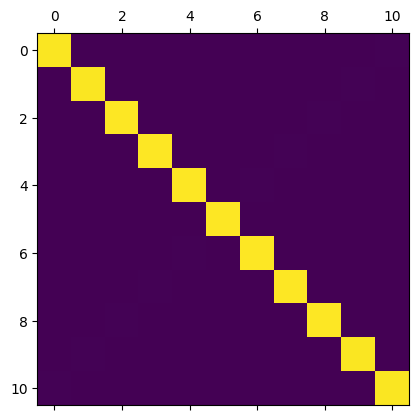

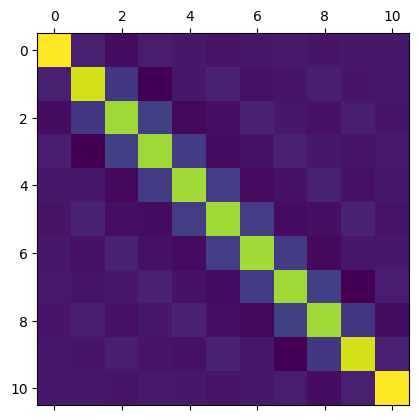

In [37]:
# Check if the blocks of matrices answers well the constraints
plt.matshow(np.real(opt_U_plus_dagger_1.conj().T@opt_U_plus_dagger_1))
plt.matshow(np.real(opt_B_U_plus_dagger.conj().T@opt_B_U_plus_dagger))

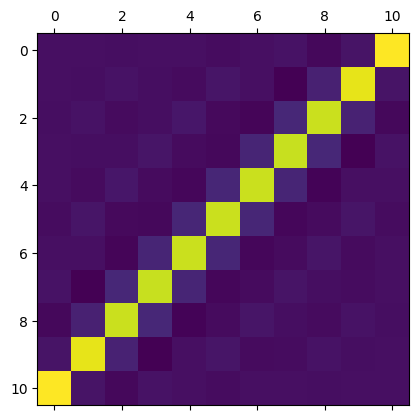

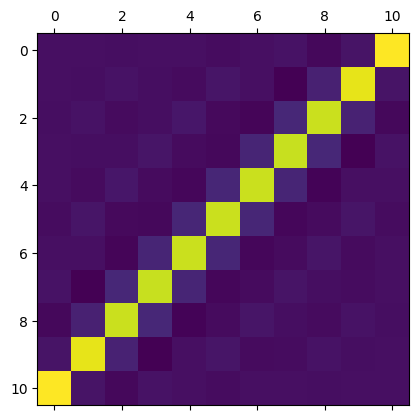

In [38]:
# Comparing the bloc of B_U_plus_dagger and B@U_plus_dagger
plt.matshow(np.real(opt_unit@W_plus[1].conj().T))
plt.matshow(np.real(opt_B_U_plus_dagger))

In [39]:
np.sqrt(np.trace((opt_unit.conj().T@opt_unit - np.eye(N_omega)).conj().T@(opt_unit.conj().T@opt_unit - np.eye(N_omega))))

(0.6914988816319984+0j)

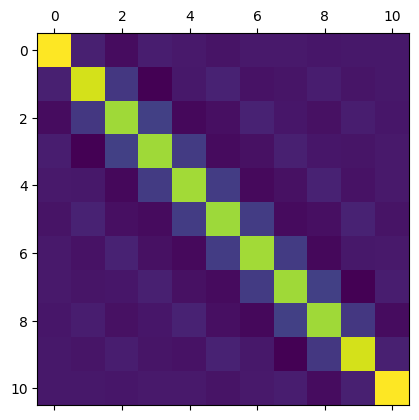

In [40]:
# The unitary matrix
plt.matshow(np.real(opt_unit.conj().T@opt_unit))

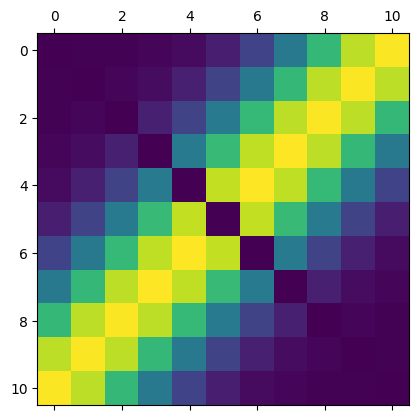

In [41]:
plt.matshow(np.abs(opt_U_plus_dagger_1.conj().T@opt_U_plus_dagger_1) - np.diag(np.diag(np.abs(opt_U_plus_dagger_1.conj().T@opt_U_plus_dagger_1))))

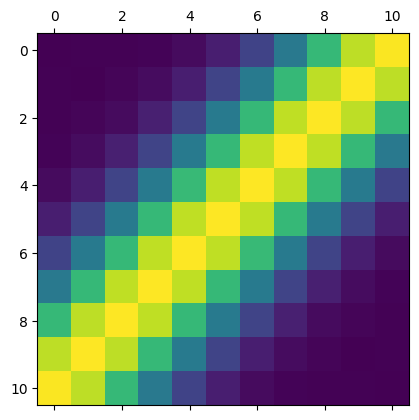

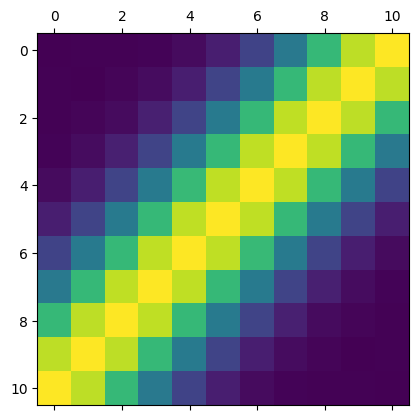

In [49]:
# Comparing optimal U_plus and theoretical U_plus
plt.matshow(np.real(W_plus[1]) - (1/np.sqrt(np.real(n)))*np.eye(N_omega))
plt.matshow(np.real(opt_U_plus_dagger_1) - (1/np.sqrt(np.real(n)))*np.eye(N_omega))

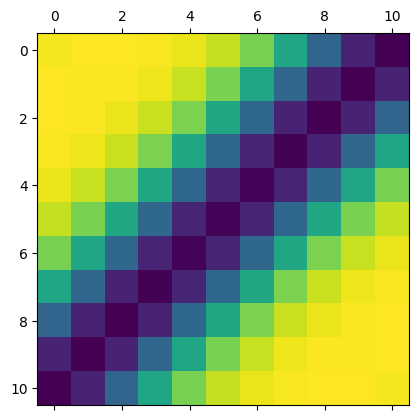

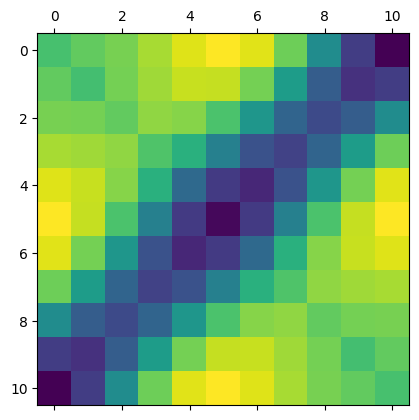

In [65]:
# Comparing optimal U_minus and theoretical U_minus
plt.matshow(np.real(W_minus[1]) - (1/np.sqrt(np.real(n)))*np.eye(N_omega))
plt.matshow(np.real(opt_U_minus_dagger_1) - (1/np.sqrt(np.real(n)))*np.eye(N_omega))

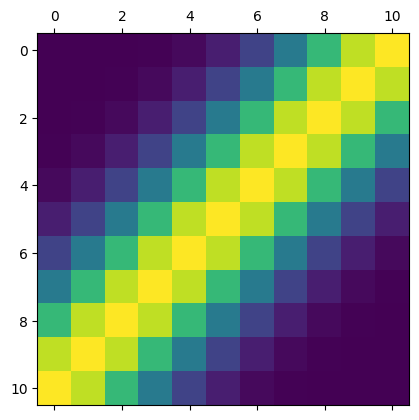

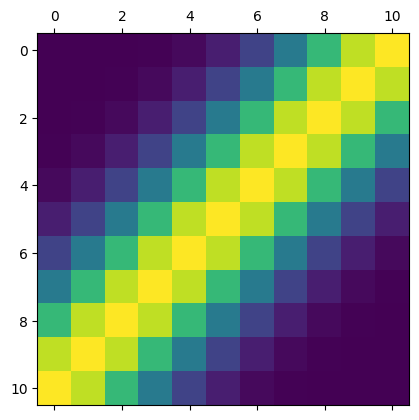

In [67]:
# Comparing the optimized beta and theoretical beta
plt.matshow(np.real(opt_beta))
plt.matshow(np.real(beta))

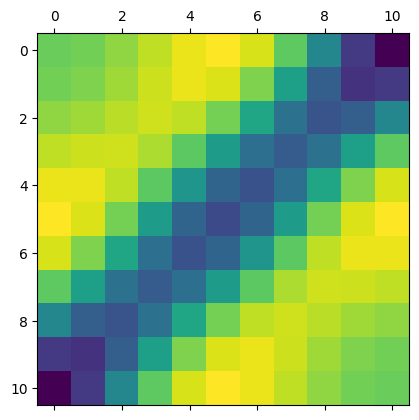

In [23]:
plt.matshow(np.real(opt_unit))

In [7]:
S, V, D = scipy.linalg.svd(W_plus[1] - W_minus[-1])

In [12]:
sum(V)

3.4681813230780016

In [25]:
unitary_mat = end_product[:N_omega, (2*N_z + 2)*N_omega:]

In [27]:
np.diag(unitary_mat.conj().T@unitary_mat)

array([0.30467053+0.j, 0.29933539+0.j, 0.2424555 +0.j, 0.2163647 +0.j,
       0.24123897+0.j, 0.26212938+0.j, 0.24123897+0.j, 0.2163647 +0.j,
       0.2424555 +0.j, 0.29933539+0.j, 0.30467053+0.j])

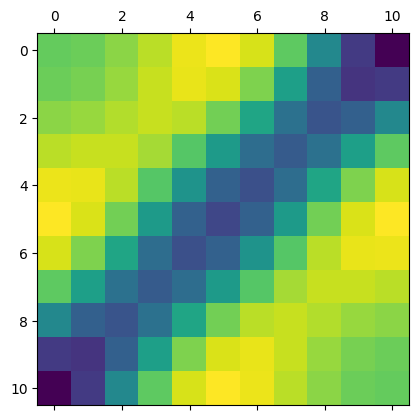

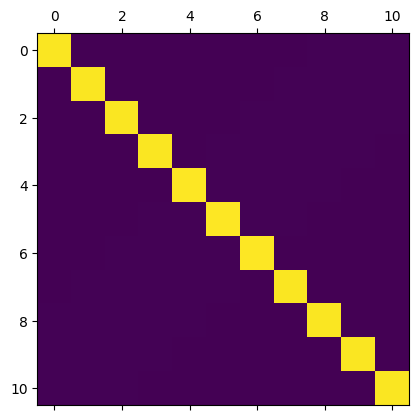

In [29]:
plt.matshow(np.real(unitary_mat.conj().T@W_plus[1]))
plt.matshow(np.real(np.real(W_plus[1])))

In [56]:
sum(V)/np.sqrt(n)

(3.5333138127727026+0j)